In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from methods.img_utils import image_grid_as_image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from datasets.nsd.nsd import NaturalScenesDataset
from datasets.nsd.nsd_measures import NSDMeasuresDataset

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

subject = 1
data_root = './data/NSD'
measures = ['warmth', 'saturation', 'brightness', 'entropy', "depth", "gaussian_curvature"]

## Linear Regression

In [ ]:
features = {}

for i, measure in enumerate(measures):

    dataset = NSDMeasuresDataset(
        nsd=NaturalScenesDataset(
            root=data_root,
            subject=subject,
            partition="train",
        ),
        measures=measure,
        patches_shape=(64, 64),
        img_shape=(448,448),
    )

    feats = []
    for i in tqdm(range(len(dataset)), total=len(dataset)):
        feats.append(dataset[i][1].flatten().numpy())
    feats = np.array(feats)
    features[measure] = feats

In [6]:
features = {}

for measure in measures:
    f = f'{subject}_{measure}.npy'
    features[measure] = np.load(f)

In [7]:
def plot_profile(hemisphere, roi, max_val=None):

    print(f"Plotting {hemisphere} {roi}")

    results = {}
    max_val = -np.inf if max_val is None else max_val

    for i, measure in enumerate(measures):

        nsd=NaturalScenesDataset(
            root=data_root,
            subject=subject,
            partition="train",
            hemisphere=hemisphere,
            roi=roi,
        )

        indices = []
        for f in nsd.df['filename']:
            idx = int(f[-18:-14]) - 1
            indices.append(idx)
        indices = np.array(indices)

        targets = nsd.fmri_data[:, nsd.roi_indices][indices]
        targets_mean = targets.mean(0, keepdims=True)
        targets_std = targets.std(0, keepdims=True)
        targets = (targets - targets_mean) / targets_std
        targets = targets.mean(1, keepdims=True)

        model = LinearRegression().fit(targets, features[measure])
        result = model.coef_[:,0].reshape(model.coef_.shape[0]//(64**2),64,64)
        results[measure] = result

        mv = np.true_divide(np.ceil(np.abs(result).max() * 10), 10)
        max_val = max(max_val, mv)

    f, axes = plt.subplots(1, len(measures), figsize=(3*len(measures),3))

    for i, measure in enumerate(measures):

        result = results[measure]

        if result.shape[0] == 1:
            result = result[0]
            p = axes[i].imshow(result, cmap='coolwarm', vmin=-max_val, vmax=max_val)
        else:
            result = result.transpose(1,2,0)
            result = (result - -0.1) / (0.1 - -0.1)
            p = axes[i].imshow(result)

        if i == (len(measures) - 1):
            plt.colorbar(p, ax=axes[i])
        
        axes[i].set_title(measure)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return results


Plotting right PPA


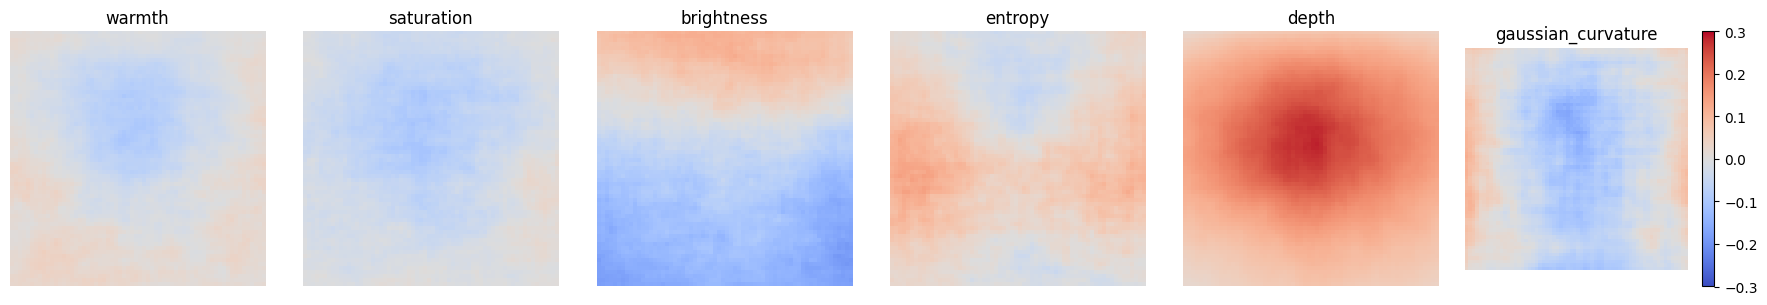

In [8]:
hemisphere = 'right'
roi = 'PPA'

results = plot_profile(hemisphere, roi, max_val=None)

In [10]:
for m in measures:
    np.save(f'{m}.npy', results[m])

8969it [00:00, 54003.09it/s]
8969it [00:00, 79421.84it/s]
8969it [00:00, 97319.14it/s]
8969it [00:00, 113122.65it/s]
8969it [00:00, 112160.07it/s]
8969it [00:00, 122247.43it/s]


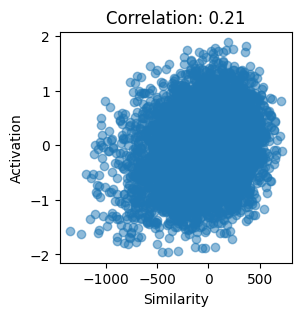

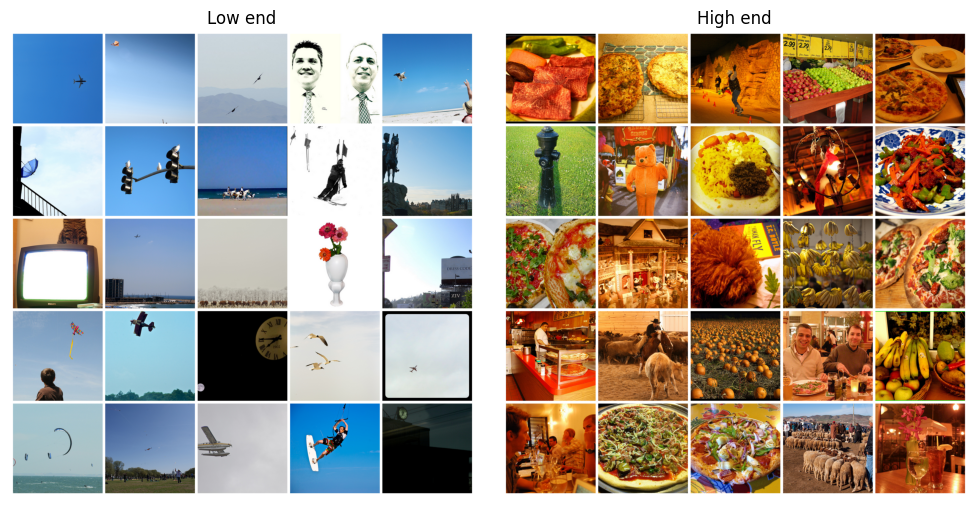

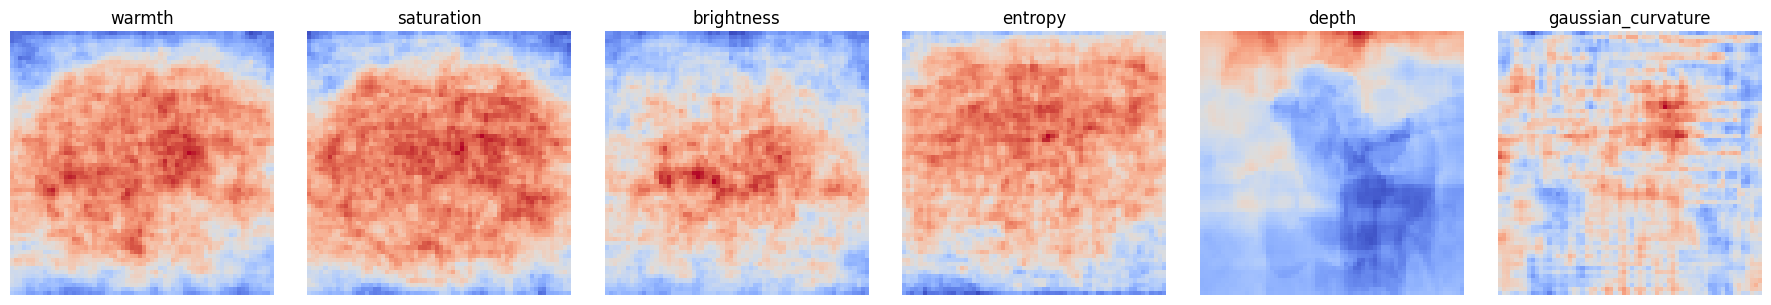

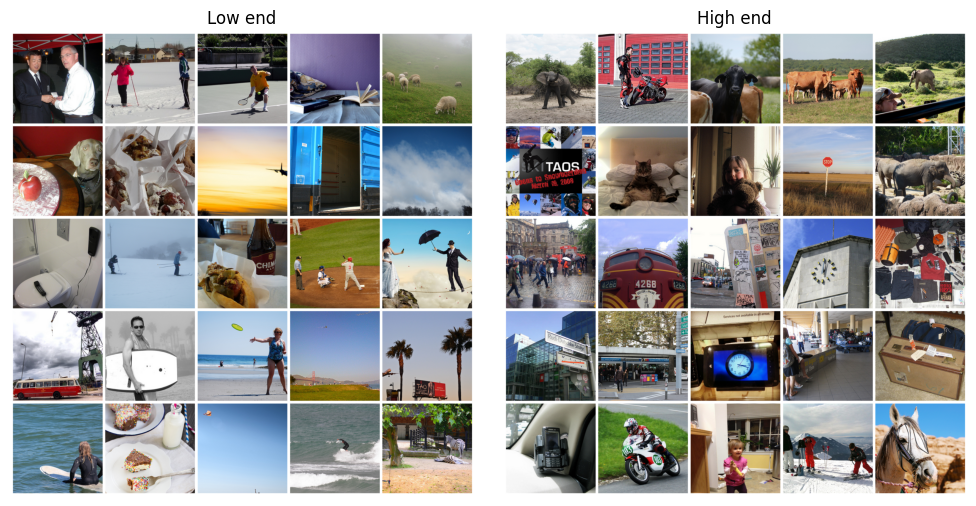

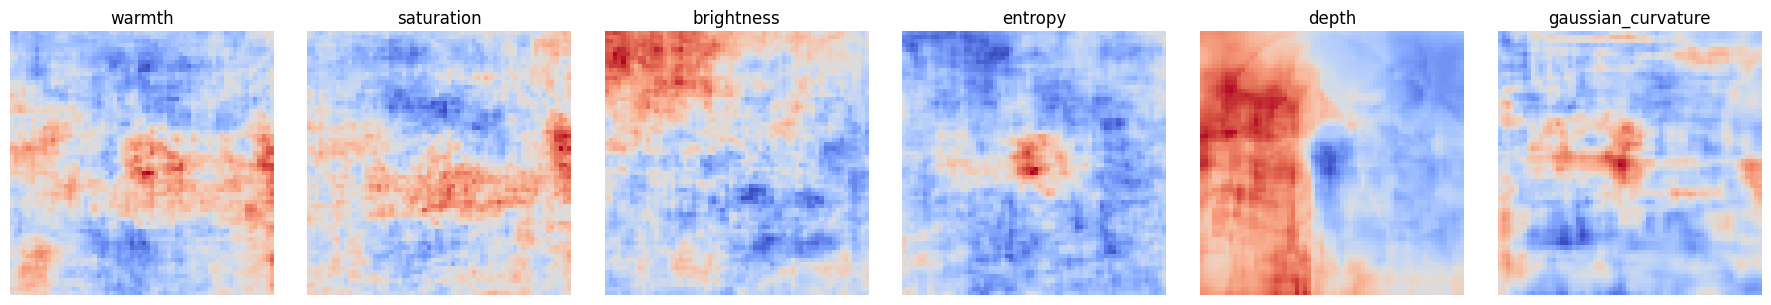

In [39]:
nsd = NaturalScenesDataset(
    root=data_root,
    subject=subject,
    partition="train",
    hemisphere=hemisphere,
    roi=roi,
)

indices = []
for f in nsd.df['filename']:
    idx = int(f[-18:-14]) - 1
    indices.append(idx)
indices = np.array(indices)

targets = nsd.fmri_data[:, nsd.roi_indices][indices]
targets_mean = targets.mean(0, keepdims=True)
targets_std = targets.std(0, keepdims=True)
targets = (targets - targets_mean) / targets_std
targets = targets.mean(1)

sims = np.zeros(len(targets))
for m in measures:
    for i, f in tqdm(enumerate(features[m])):
        sims[i] += np.dot(f.flatten(), results[m].flatten())
sims = np.array(sims)

plt.figure(figsize=(3,3))
plt.scatter(sims, targets, alpha=0.5)
plt.xlabel('Similarity')
plt.ylabel('Activation')
plt.title(f'Correlation: {np.corrcoef(sims, targets)[0,1]:.2f}')
plt.show()

order = np.argsort(sims)
min_idx = order[:100]
min_images = [Image.open(os.path.join(nsd.root, nsd.df.iloc[idx]["filename"])) for idx in min_idx]
max_idx = order[-100:][::-1].copy()
max_images = [Image.open(os.path.join(nsd.root, nsd.df.iloc[idx]["filename"])) for idx in max_idx]
min_image = image_grid_as_image(min_images, 5, 5)
max_image = image_grid_as_image(max_images, 5, 5)

f, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(min_image)
axes[0].axis('off')
axes[0].set_title("Low end")
axes[1].imshow(max_image)
axes[1].axis('off')
axes[1].set_title("High end")
plt.tight_layout()
plt.show()

f, axes = plt.subplots(1, len(measures), figsize=(3*len(measures),3))
for i, measure in enumerate(measures):
    feats = features[measure]
    feats = feats[max_idx].mean(0).reshape(64,64)
    axes[i].imshow(feats, cmap='coolwarm')
    axes[i].set_title(measure)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

order = np.argsort(targets.numpy())
min_idx = order[:100]
min_images = [Image.open(os.path.join(nsd.root, nsd.df.iloc[idx]["filename"])) for idx in min_idx]
max_idx = order[-100:][::-1].copy()
max_images = [Image.open(os.path.join(nsd.root, nsd.df.iloc[idx]["filename"])) for idx in max_idx]
min_image = image_grid_as_image(min_images, 5, 5)
max_image = image_grid_as_image(max_images, 5, 5)

f, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(min_image)
axes[0].axis('off')
axes[0].set_title("Low end")
axes[1].imshow(max_image)
axes[1].axis('off')
axes[1].set_title("High end")
plt.tight_layout()
plt.show()

f, axes = plt.subplots(1, len(measures), figsize=(3*len(measures),3))
for i, measure in enumerate(measures):
    feats = features[measure]
    feats = feats[max_idx].mean(0).reshape(64,64)
    axes[i].imshow(feats, cmap='coolwarm')
    axes[i].set_title(measure)
    axes[i].axis('off')
plt.tight_layout()
plt.show()